# 1. Data Gathering

#### (a) Download the parking violations dataset for 2017 - 2022 (≈10.5GB) from the following website https://data.cityofnewyork.us/City-Government/Parking-Violations-Issued-Fiscal-Year-2023/pvqr-7yc4

#### (b) Store all the CSV data in a single AWS S3 bucket via the AWS Academy Learner Lab (Big Data Containers) class. You may manually upload the data or use the code provided in the S3 tutorial to upload the data to the bucket.

![Buckets](https://cdn.discordapp.com/attachments/1012099908557344791/1029833420135747664/bucketsScreentshot.png)


#### (c) Create a second bucket that will store the intermediate steps of your work as parquet files.
![CSV Files](https://cdn.discordapp.com/attachments/1012099908557344791/1029833420521607239/csvScreenshot.png)

In [69]:
# Import needed libraries
import os
import logging
import boto3
from botocore.exceptions import ClientError
import sys
import threading
import pandas as pd
import requests
import io
import s3fs
from functools import reduce
import numpy as np
from datetime import datetime

from dask_saturn import ExternalConnection, SaturnCluster
from dask.distributed import Client
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

# Set ENV Vars
%env SATURN_BASE_URL=https://app.community.saturnenterprise.io
%env SATURN_TOKEN=server-80a185b8b3624752be65ef2a3adb0c38


env: SATURN_BASE_URL=https://app.community.saturnenterprise.io
env: SATURN_TOKEN=server-80a185b8b3624752be65ef2a3adb0c38


# 2. Data Cleaning

#### (a) Load the data from your S3 bucket into dask using a cluster (eg. Saturn Cloud or AWS ECS)

In [38]:
# Connect to SaturnCloud cluster
cluster = SaturnCluster()
client = Client(cluster)
client

INFO:dask-saturn:Cluster is ready
INFO:dask-saturn:Registering default plugins
INFO:dask-saturn:Success!


<Client: 'tcp://192.168.206.194:8786' processes=3 threads=6, memory=43.31 GiB>

In [39]:
# Connect to S3 Bucket with all CSVs and show all loaded
s3 = s3fs.S3FileSystem(anon=True)
s3path = 's3://nyc-parking-violations-csv/'
s3.ls(s3path)
# %reset

['nyc-parking-violations-csv/Parking_Violations_Issued_-_Fiscal_Year_2017.csv',
 'nyc-parking-violations-csv/Parking_Violations_Issued_-_Fiscal_Year_2018.csv',
 'nyc-parking-violations-csv/Parking_Violations_Issued_-_Fiscal_Year_2019.csv',
 'nyc-parking-violations-csv/Parking_Violations_Issued_-_Fiscal_Year_2020.csv',
 'nyc-parking-violations-csv/Parking_Violations_Issued_-_Fiscal_Year_2021.csv',
 'nyc-parking-violations-csv/Parking_Violations_Issued_-_Fiscal_Year_2022.csv',
 'nyc-parking-violations-csv/Parking_Violations_Issued_-_Fiscal_Year_2023.csv']

In [5]:
#test = dd.read_parquet('s3://nyc-parking-violations-parquet/test')

In [6]:
#test = dd.read_csv('s3://nyc-parking-violations-csv/Parking_Violations_Issued_-_Fiscal_Year_2023.csv')

In [40]:
# Build dataframes from S3 by reading CSV in from built path
files = s3.ls(s3path)

def load_data_individually(filepaths, aws=False):
    bucket = ''
    
    if aws:
        bucket = 's3://'
        
    dataframes = {}
    with ProgressBar():
        for file in files:
            path = bucket + file
            dataframes[file[-8:-4]] = dd.read_csv(path)
    return dataframes

dataframes = load_data_individually(files, True)
# client.persist(dataframes)

#### (b) Find the common columns between each dataset.

In [43]:
# Use list comprehension to build a single list with every unique column across all CSVs
def find_common_columns(dataframes):
    columns = [set(dataframes[x].columns) for x in dataframes]
    common_columns = list(reduce(lambda a, i: a.intersection(i), columns))
    return common_columns

# Using all dataframes loaded find all unique columns and display
common_columns = find_common_columns(dataframes)
common_columns

['Street Code2',
 'Intersecting Street',
 'Vehicle Year',
 'Hydrant Violation',
 'Violation Post Code',
 'Time First Observed',
 'Vehicle Expiration Date',
 'Plate Type',
 'Violation Location',
 'Issuer Command',
 'Violation Time',
 'Registration State',
 'Unregistered Vehicle?',
 'Street Name',
 'Issuer Code',
 'Law Section',
 'Violation County',
 'Issue Date',
 'Plate ID',
 'Issuing Agency',
 'Date First Observed',
 'Sub Division',
 'Double Parking Violation',
 'Street Code3',
 'Vehicle Color',
 'Violation Code',
 'Violation Precinct',
 'Violation In Front Of Or Opposite',
 'Street Code1',
 'From Hours In Effect',
 'Meter Number',
 'Feet From Curb',
 'Vehicle Make',
 'House Number',
 'Violation Legal Code',
 'No Standing or Stopping Violation',
 'Summons Number',
 'Vehicle Body Type',
 'Issuer Squad',
 'To Hours In Effect',
 'Violation Description',
 'Issuer Precinct']

In [44]:
print(f"Number of Common Columns: {len(common_columns)}")

Number of Common Columns: 42


#### (c) Either create your own meaningful schema based on the common columns in the dataset or use the schema presented on the slides

In [45]:
# DTypes provided by Dr. Fitz in course slides

dtypes = {
 'Date First Observed': np.str_,
 'Days Parking In Effect    ': np.str_,
 'Double Parking Violation': np.str_,
 'Feet From Curb': np.float32,
 'From Hours In Effect': np.str_,
 'House Number': np.str_,
 'Hydrant Violation': np.str_,
 'Intersecting Street': np.str_,
 'Issue Date': np.str_,
 'Issuer Code': np.float32,
 'Issuer Command': np.str_,
 'Issuer Precinct': np.float32,
 'Issuer Squad': np.str_,
 'Issuing Agency': np.str_,
 'Law Section': np.float32,
 'Meter Number': np.str_,
 'No Standing or Stopping Violation': np.str_,
 'Plate ID': np.str_,
 'Plate Type': np.str_,
 'Registration State': np.str_,
 'Street Code1': np.uint32,
 'Street Code2': np.uint32,
 'Street Code3': np.uint32,
 'Street Name': np.str_,
 'Sub Division': np.str_,
 'Summons Number': np.uint32,
 'Time First Observed': np.str_,
 'To Hours In Effect': np.str_,
 'Unregistered Vehicle?': np.str_,
 'Vehicle Body Type': np.str_,
 'Vehicle Color': np.str_,
 'Vehicle Expiration Date': np.str_,
 'Vehicle Make': np.str_,
 'Vehicle Year': np.uint32,
 'Violation Code': np.uint16,
 'Violation County': np.str_,
 'Violation Description': np.str_,
 'Violation In Front Of Or Opposite': np.str_,
 'Violation Legal Code': np.str_,
 'Violation Location': np.str_,
 'Violation Post Code': np.str_,
 'Violation Precinct': np.float32,
 'Violation Time': np.str_
}

In [46]:
# Read in all CSVs with specified DTypes and all columns
nyc_data_raw = dd.read_csv('s3://nyc-parking-violations-csv/*.csv', dtype=dtypes, usecols=common_columns)

# client.persist(nyc_data_raw)

#### (d) Find the percentage of missing values in the dataset

In [52]:
%%time

# Find all null values in data set and sum them
missing_values = nyc_data_raw.isnull().sum()

# With the total number of null vals, find the percentage of each column
with ProgressBar():
    percent_missing = ((missing_values / nyc_data_raw.index.size) * 100).compute()
percent_missing

CPU times: user 277 ms, sys: 41.5 ms, total: 318 ms
Wall time: 4min 20s


Summons Number                         0.000000
Plate ID                               0.002325
Registration State                     0.000000
Plate Type                             0.000000
Issue Date                             0.000380
Violation Code                         0.000000
Vehicle Body Type                      0.325483
Vehicle Make                           0.405139
Issuing Agency                         0.000002
Street Code1                           0.000000
Street Code2                           0.000000
Street Code3                           0.000000
Vehicle Expiration Date                0.000000
Violation Location                    28.558537
Violation Precinct                     0.000000
Issuer Precinct                        0.000000
Issuer Code                            0.000000
Issuer Command                        28.323948
Issuer Squad                          29.064128
Violation Time                         0.001230
Time First Observed                   94

#### (e) Drop columns with missing values >=50%

In [49]:
# If more than 50% of the column is missing, we will drop it and save new dataframe to new var
with ProgressBar():
    columns_to_drop = list(percent_missing[percent_missing >= 50].index)
    nyc_data_clean_stage1 = nyc_data_raw.drop(columns_to_drop, axis=1)
    
nyc_data_clean_stage1.head()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,House Number,Street Name,Date First Observed,Law Section,Sub Division,Vehicle Color,Vehicle Year,Feet From Curb,Violation Post Code,Violation Description
0,797502185,GZH7067,NY,PAS,07/10/2016,7,SUBN,TOYOT,V,0,...,NaN,ALLERTON AVE (W/B) @,0,1111.0,D,GY,2001,0.0,NaN,FAILURE TO STOP AT RED LIGHT
1,797484362,GZH7067,NY,PAS,07/08/2016,7,SUBN,TOYOT,V,0,...,NaN,ALLERTON AVE (W/B) @,0,1111.0,D,GY,2001,0.0,NaN,FAILURE TO STOP AT RED LIGHT
2,336666088,AVM7975,NY,PAS,03/09/2017,36,SUBN,GMC,V,0,...,NaN,WB LINDEN BLVD @ LIN,0,1180.0,B,GY,2010,0.0,NaN,PHTO SCHOOL ZN SPEED VIOLATION
3,3901589984,GWB7054,NY,PAS,01/18/2017,70,SUBN,TOYOT,T,59590,...,35-11,Prince St,0,408.0,j3,BL,2015,0.0,05,70A-Reg. Sticker Expired (NYS)
4,336217062,EXZ9820,NY,PAS,03/02/2017,36,4DSD,HONDA,V,0,...,NaN,WB FLATLANDS AVE @ E,0,1180.0,B,GR,1997,0.0,NaN,PHTO SCHOOL ZN SPEED VIOLATION


#### (f) Impute the most common vehicle color into the records that are missing a vehicle color


In [55]:
# With the cleaned data, get the count of car colors
with ProgressBar():
    count_of_vehicle_colors = nyc_data_clean_stage1['Vehicle Color'].value_counts().compute()

# Find the most common color and fill all null colors with it. 
most_common_color = count_of_vehicle_colors.sort_values(ascending=False).index[0]
print(f"The most common color was: {most_common_color}")
nyc_data_clean_stage2 = nyc_data_clean_stage1.fillna({'Vehicle Color': most_common_color})

The most common color was: GY


#### (g) Drop rows with missing values of <= 5%


In [59]:
# If a row has 0 to 4.99999 percent, it will be kept. Otherwise, drop the row. 
rows_to_drop = list(percent_missing[(percent_missing > 0) & (percent_missing <= 5)].index)
nyc_data_clean_stage3 = nyc_data_clean_stage2.dropna(subset=rows_to_drop)

In [57]:
# Before we drop the rows with <= 5% missing
with ProgressBar():
    print(len(nyc_data_clean_stage2))

80012109


In [58]:
# After we drop the rows with <= 5% missing
with ProgressBar():
    print(len(nyc_data_clean_stage3))

79245726


#### (h) Fill the missing values with the default value of "Unknown" for any column of string data type that has more than 5% missing values and less than 50% missing values.


In [19]:
# Gather columns still left to be replaces with "Unknown"
remaining_columns_to_clean = list(percent_missing[(percent_missing >= 5) & (percent_missing < 50)].index)
nyc_data_raw.dtypes[remaining_columns_to_clean]

Violation Location                   object
Issuer Command                       object
Issuer Squad                         object
Violation In Front Of Or Opposite    object
House Number                         object
Violation Post Code                  object
Violation Description                object
dtype: object

In [61]:
# For each of the remaining columns, build a dict with the column name and "Unknown"
unknown_default_dict = dict(map(lambda columnName: (columnName, 'Unknown'), remaining_columns_to_clean))
# Fill each null value according to the key value pairs from the dict
nyc_data_clean_stage4 = nyc_data_clean_stage3.fillna(unknown_default_dict)

In [62]:
# Prove all data isn't null anymore
with ProgressBar():
    display(nyc_data_clean_stage4.isnull().sum().compute())
nyc_data_clean_stage4.persist()

Summons Number                       0
Plate ID                             0
Registration State                   0
Plate Type                           0
Issue Date                           0
Violation Code                       0
Vehicle Body Type                    0
Vehicle Make                         0
Issuing Agency                       0
Street Code1                         0
Street Code2                         0
Street Code3                         0
Vehicle Expiration Date              0
Violation Location                   0
Violation Precinct                   0
Issuer Precinct                      0
Issuer Code                          0
Issuer Command                       0
Issuer Squad                         0
Violation Time                       0
Violation County                     0
Violation In Front Of Or Opposite    0
House Number                         0
Street Name                          0
Date First Observed                  0
Law Section              

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Date First Observed,Law Section,Sub Division,Vehicle Color,Vehicle Year,Feet From Curb,Violation Post Code,Violation Description
npartitions=228,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,uint32,object,object,object,object,uint16,object,object,object,uint32,uint32,uint32,object,object,float32,float32,float32,object,object,object,object,object,object,object,object,float32,object,object,uint32,float32,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


#### (i) Recode the Plate Type column to have only 3 types (PAS, COM, and Other). That is, change all plate types that are not PAS or COM to "Other".


In [63]:
# Show original plate type count
with ProgressBar():
    display(nyc_data_clean_stage4['Plate Type'].value_counts().compute())

PAS    61087763
COM    11360044
OMT     3073905
SRF      763229
OMS      749176
         ...   
GAC           8
JWV           8
SNO           4
HIF           3
LOC           3
Name: Plate Type, Length: 90, dtype: int64

In [64]:
# isin returns True if the value is contained in the list of objects, otherwise false
condition = nyc_data_clean_stage4['Plate Type'].isin(['PAS', 'COM'])

# Find records where the condition is satisfied; replace all others with ‘Other’
plate_type_masked = nyc_data_clean_stage4['Plate Type'].where(condition, 'Other')

# Drop the old Plate Type column completely
nyc_data_recode_stage1 = nyc_data_clean_stage4.drop('Plate Type', axis=1)

# Create a new column named PlateType with the updated data
nyc_data_recode_stage2 = nyc_data_recode_stage1.assign(PlateType=plate_type_masked)

# Rename this new column to the original "Plate Type"
nyc_data_recode_stage3 = nyc_data_recode_stage2.rename(columns={'PlateType': 'Plate Type'})

In [65]:
# Show updated plate type count
with ProgressBar():
    display(nyc_data_recode_stage3['Plate Type'].value_counts().compute())

PAS      61087763
COM      11360044
Other     6797919
Name: Plate Type, dtype: int64

#### (j) Change all vehicle colors that appear only once to "Other"


In [66]:
# Show original color counts
with ProgressBar():
    display(nyc_data_recode_stage3['Vehicle Color'].value_counts().compute())

GY       17063924
WH       14163643
BK       12576097
WHITE     7186696
BL        4860439
           ...   
HGN             1
HGRY            1
HGY             1
HIK             1
`BRN            1
Name: Vehicle Color, Length: 4743, dtype: int64

In [67]:
# List for colors that appear once
single_color = list(count_of_vehicle_colors[count_of_vehicle_colors==1].index)

# Bool for mask in vehicle color
condition = nyc_data_clean_stage4['Vehicle Color'].isin(single_color)

# Mask vehicle color
vehicle_color_masked = nyc_data_clean_stage4['Vehicle Color'].mask(condition, 'Other')

# Drop column old
nyc_data_recode_stage4 = nyc_data_recode_stage3.drop('Vehicle Color', axis=1)

# Assign new column
nyc_data_recode_stage5 = nyc_data_recode_stage4.assign(VehicleColor=vehicle_color_masked)

# Rename column to proper form
nyc_data_recode_stage6 = nyc_data_recode_stage5.rename(columns={'VehicleColor':'Vehicle Color'})

In [68]:
# Show updated color counts 
with ProgressBar():
    display(nyc_data_recode_stage6['Vehicle Color'].value_counts().compute())

GY       17063924
WH       14163643
BK       12576097
WHITE     7186696
BL        4860439
           ...   
WIL             1
BLU/B           1
BK W            1
UD              1
OB              1
Name: Vehicle Color, Length: 2585, dtype: int64

#### (k) Convert the data type of the Issue Date column to date


In [70]:
# Date data before
with ProgressBar():
    display(nyc_data_recode_stage6['Issue Date'].head())

0    07/10/2016
1    07/08/2016
2    03/09/2017
3    01/18/2017
4    03/02/2017
Name: Issue Date, dtype: object

In [71]:
# Parse the issue date column and correct it with a proper format
issue_date_parsed = nyc_data_recode_stage6['Issue Date'].apply(lambda x: datetime.strptime(x[:10], "%m/%d/%Y"), meta=datetime)
nyc_data_derived_stage1 = nyc_data_recode_stage6.drop('Issue Date', axis=1)
nyc_data_derived_stage2 = nyc_data_derived_stage1.assign(IssueDate=issue_date_parsed)
nyc_data_derived_stage3 = nyc_data_derived_stage2.rename(columns={'IssueDate':'Issue Date'})

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/dask/dataframe/core.py:6335: FutureWarning: Meta is not valid, `map_partitions` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


In [72]:
# Date data after correction
with ProgressBar():
    display(nyc_data_derived_stage3['Issue Date'].head())

0   2016-07-10
1   2016-07-08
2   2017-03-09
3   2017-01-18
4   2017-03-02
Name: Issue Date, dtype: datetime64[ns]

#### (l) Create a new column named "Citation Issued Month Year" that has a string representation of the month/year that the citation was issued (example: "202109" for September 2021.)

In [73]:
# Extracting the month and year
issue_date_month_year = nyc_data_derived_stage3['Issue Date'].apply(lambda dt: dt.strftime("%Y%m"), meta=str)
nyc_data_derived_stage4 = nyc_data_derived_stage3.assign(IssueMonthYear=issue_date_month_year)
nyc_data_derived_stage5 = nyc_data_derived_stage4.rename(columns={'IssueMonthYear':'Citation Issued Month Year'})

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/dask/dataframe/core.py:6335: FutureWarning: Meta is not valid, `map_partitions` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


In [74]:
# Inspecting the newly derived column
with ProgressBar():
    display(nyc_data_derived_stage5['Citation Issued Month Year'].head())

0    201607
1    201607
2    201703
3    201701
4    201703
Name: Citation Issued Month Year, dtype: object

In [75]:
nyc_data_clean = nyc_data_derived_stage5.persist()

In [76]:
# Show finalized data for Part 2
nyc_data_clean.head(10)

,Summons Number,Plate ID,Registration State,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,...,Law Section,Sub Division,Vehicle Year,Feet From Curb,Violation Post Code,Violation Description,Plate Type,Vehicle Color,Issue Date,Citation Issued Month Year
0,797502185,GZH7067,NY,7,SUBN,TOYOT,V,0,0,0,...,1111.0,D,2001,0.0,Unknown,FAILURE TO STOP AT RED LIGHT,PAS,GY,2016-07-10,201607
1,797484362,GZH7067,NY,7,SUBN,TOYOT,V,0,0,0,...,1111.0,D,2001,0.0,Unknown,FAILURE TO STOP AT RED LIGHT,PAS,GY,2016-07-08,201607
2,336666088,AVM7975,NY,36,SUBN,GMC,V,0,0,0,...,1180.0,B,2010,0.0,Unknown,PHTO SCHOOL ZN SPEED VIOLATION,PAS,GY,2017-03-09,201703
3,3901589984,GWB7054,NY,70,SUBN,TOYOT,T,59590,8590,57790,...,408.0,j3,2015,0.0,05,70A-Reg. Sticker Expired (NYS),PAS,BL,2017-01-18,201701
4,336217062,EXZ9820,NY,36,4DSD,HONDA,V,0,0,0,...,1180.0,B,1997,0.0,Unknown,PHTO SCHOOL ZN SPEED VIOLATION,PAS,GR,2017-03-02,201703
5,4007039033,GZE1511,NY,5,4DSD,TOYOT,V,0,0,0,...,1111.0,C,2001,0.0,Unknown,BUS LANE VIOLATION,PAS,WH,2017-03-06,201703
6,3367768768,83485MH,NY,48,VAN,FRUEH,T,0,40404,40404,...,408.0,e9,2016,0.0,01 7,48-Bike Lane,COM,BROWN,2016-07-20,201607
7,4244393356,GEH9367,NY,70,4DSD,DODGE,T,31830,5430,5580,...,408.0,j3,2011,0.0,19,70A-Reg. Sticker Expired (NYS),PAS,GY,2017-05-04,201705
8,3998577006,FYP7892,NY,14,SUBN,TOYOT,T,14380,35980,36030,...,408.0,c,2016,0.0,CC1,14-No Standing,PAS,WH,2016-10-03,201610
9,4230994939,HHM1058,NY,21,4DSD,ME/BE,T,35720,34020,22020,...,408.0,d1,2015,0.0,03,21-No Parking (street clean),PAS,WH,2017-04-20,201704


# 3. EDA

#### (a) Filter the data to have citations issued between 2017-01-01 and 2022-12-31.

In [165]:
# nyc_data_derived_stage5 = dd.read_parquet('s3://nyc-parking-violations-parquet/nyc_data_derived_stage5')
with ProgressBar():
    condition = (nyc_data_clean['Issue Date'] > '2017-01-01') & (nyc_data_clean['Issue Date'] <= '2022-12-31')
    nyc_data_filtered = nyc_data_clean[condition]
    nyc_data_new_index = nyc_data_filtered.set_index('Citation Issued Month Year')

In [166]:
with ProgressBar():
    display(nyc_data_new_index.head())

,Summons Number,Plate ID,Registration State,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,...,Date First Observed,Law Section,Sub Division,Vehicle Year,Feet From Curb,Violation Post Code,Violation Description,Plate Type,Vehicle Color,Issue Date
Citation Issued Month Year,,,,,,,,,,,,,,,,,,,,,
201701,3901589984,GWB7054,NY,70,SUBN,TOYOT,T,59590,8590,57790,...,0,408.0,j3,2015,0.0,05,70A-Reg. Sticker Expired (NYS),PAS,BL,2017-01-18
201701,3427885508,BAS3436,NY,31,SUBN,HONDA,T,34350,10610,10810,...,0,408.0,l3,2017,0.0,01,31-No Stand (Com. Mtr. Zone),PAS,GY,2017-01-31
201701,4188838366,41006PC,NY,47,TK,FRUEH,T,10610,34470,34490,...,0,408.0,l2,2015,0.0,99,47-Double PKG-Midtown,Other,MR,2017-01-21
201701,3364859027,KSMRNTUC,NY,37,4DSD,FORD,T,10210,18770,18790,...,0,408.0,h1,2012,0.0,09,37-Expired Muni Meter,Other,BL,2017-01-21
201701,2725746864,187TJ5,MA,21,2DSD,AUDI,T,0,0,0,...,0,408.0,d1,0,0.0,11,21-No Parking (street clean),PAS,OTHER,2017-01-19


#### (b) Repartition the data to have a new index of month year (eg: 202109) from 2017 - 2021.

In [167]:
with ProgressBar():
    display(nyc_data_filtered['Citation Issued Month Year'].value_counts().index.compute())

Index(['202208', '202009', '202106', '202206', '202108', '202010', '202107',
       '202008', '202203', '202103', '202207', '202205', '202110', '202204',
       '201908', '202111', '201910', '202011', '202101', '201909', '202104',
       '202105', '202109', '202001', '201911', '202112', '202012', '201907',
       '202002', '201810', '201805', '201710', '202202', '202201', '202003',
       '202007', '201901', '201706', '201711', '201705', '201811', '201806',
       '201804', '201912', '201709', '201803', '201903', '201905', '201807',
       '201703', '201707', '201808', '201708', '201812', '201802', '201801',
       '201809', '201904', '201704', '201701', '201906', '201902', '201702',
       '201712', '202102', '202006', '202004', '202005', '202212', '202209',
       '202211', '202210'],
      dtype='object')

In [168]:
with ProgressBar():
    years_months = list(nyc_data_filtered['Citation Issued Month Year'].value_counts().index.compute())

In [169]:
years_months.sort()

In [170]:
with ProgressBar():
    nyc_data_new_index.repartition(divisions=years_months)
# nyc_data_new_index = dd.read_parquet('nyc_data_date_index')

In [171]:
with ProgressBar():
    display(nyc_data_new_index.head())

,Summons Number,Plate ID,Registration State,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,...,Date First Observed,Law Section,Sub Division,Vehicle Year,Feet From Curb,Violation Post Code,Violation Description,Plate Type,Vehicle Color,Issue Date
Citation Issued Month Year,,,,,,,,,,,,,,,,,,,,,
201701,3901589984,GWB7054,NY,70,SUBN,TOYOT,T,59590,8590,57790,...,0,408.0,j3,2015,0.0,05,70A-Reg. Sticker Expired (NYS),PAS,BL,2017-01-18
201701,3427885508,BAS3436,NY,31,SUBN,HONDA,T,34350,10610,10810,...,0,408.0,l3,2017,0.0,01,31-No Stand (Com. Mtr. Zone),PAS,GY,2017-01-31
201701,4188838366,41006PC,NY,47,TK,FRUEH,T,10610,34470,34490,...,0,408.0,l2,2015,0.0,99,47-Double PKG-Midtown,Other,MR,2017-01-21
201701,3364859027,KSMRNTUC,NY,37,4DSD,FORD,T,10210,18770,18790,...,0,408.0,h1,2012,0.0,09,37-Expired Muni Meter,Other,BL,2017-01-21
201701,2725746864,187TJ5,MA,21,2DSD,AUDI,T,0,0,0,...,0,408.0,d1,0,0.0,11,21-No Parking (street clean),PAS,OTHER,2017-01-19


#### (c) Save the repartititioned data to an AWS S3 bucket as parquet files.

In [181]:
with ProgressBar():
    nyc_data_new_index.to_parquet('s3://nyc-parking-violations-parquet/nyc_data_new_index',engine='pyarrow', storage_options={'anon': False}, overwrite=True)
# %reset

#### (d) Use the techniques demonstrated in class to pull the average monthly temperature data from NOAA API from 2017-2021. Create an in-memory DataFrame with your results and augment the ticket data with the temperature data. Do not hard-code any data or use any external files.


In [158]:
s3parquet = 's3://nyc-parking-violations-parquet/'
s3.ls(s3parquet)

['nyc-parking-violations-parquet/nyc_data_new_index',
 'nyc-parking-violations-parquet/test']

In [161]:
nyc_data_new_index = dd.read_parquet('s3://nyc-parking-violations-parquet/nyc_data_new_index/',engine='pyarrow')

In [173]:
nyc_data_new_index.head()

,Summons Number,Plate ID,Registration State,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,...,Date First Observed,Law Section,Sub Division,Vehicle Year,Feet From Curb,Violation Post Code,Violation Description,Plate Type,Vehicle Color,Issue Date
Citation Issued Month Year,,,,,,,,,,,,,,,,,,,,,
201701,3901589984,GWB7054,NY,70,SUBN,TOYOT,T,59590,8590,57790,...,0,408.0,j3,2015,0.0,05,70A-Reg. Sticker Expired (NYS),PAS,BL,2017-01-18
201701,3427885508,BAS3436,NY,31,SUBN,HONDA,T,34350,10610,10810,...,0,408.0,l3,2017,0.0,01,31-No Stand (Com. Mtr. Zone),PAS,GY,2017-01-31
201701,4188838366,41006PC,NY,47,TK,FRUEH,T,10610,34470,34490,...,0,408.0,l2,2015,0.0,99,47-Double PKG-Midtown,Other,MR,2017-01-21
201701,3364859027,KSMRNTUC,NY,37,4DSD,FORD,T,10210,18770,18790,...,0,408.0,h1,2012,0.0,09,37-Expired Muni Meter,Other,BL,2017-01-21
201701,2725746864,187TJ5,MA,21,2DSD,AUDI,T,0,0,0,...,0,408.0,d1,0,0.0,11,21-No Parking (street clean),PAS,OTHER,2017-01-19


In [174]:
import requests
from pprint import pprint

api_key = os.environ.get('NOAA_API_KEY')
headers = {'token':api_key}
dataset = 'https://www.ncei.noaa.gov/cdo-web/api/v2/datasets'
location = 'https://www.ncei.noaa.gov/cdo-web/api/v2/locations'
datatype = 'https://www.ncei.noaa.gov/cdo-web/api/v2/datatypes?datasetid=GSOM&datacategoryid=TEMP'
newyorkinfo = 'https://www.ncei.noaa.gov/cdo-web/api/v2/stations?locationid=FIPS:36&sortfield=mindate'


offset = 1
pageurl = 'https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GSOM&stationid=GHCND:USW00094728&datatypeid=TAVG&startdate=2017-01-01&enddate=2021-12-31&limit=1000&offset='

temperature = []

# print(response.json()['metadata']['resultset']['limit'])

#Pagination
while True:
    response = requests.get(pageurl + str(offset), headers=headers)
    
    if response.status_code == 200:
        json = response.json()
        count = json['metadata']['resultset']['count']
        limit = json['metadata']['resultset']['limit']
        offset = json['metadata']['resultset']['offset']
        
        temperature.extend(json['results'])
        if offset*limit < count:
            offset += 1
        else:
            break
    else:
        print(response.content)
        break;
        
tempdf = pd.DataFrame(temperature).drop(['datatype','station','attributes'], axis=1)
tempdf_date = pd.to_datetime(tempdf['date'])


tempdf_format = tempdf_date.apply(lambda x: x.strftime('%Y%m'))
tempdf_stage1 = tempdf.drop(['date'], axis=1)
tempdf_stage2 = tempdf_stage1.assign(Date=tempdf_format)
tempdf_stage3 = tempdf_stage2.rename(columns={'value':'Average Temperature (Celsius)'})


In [218]:
tempdf_new_index = tempdf_stage3.set_index(tempdf_stage3.Date.astype(str))

In [226]:
augmented_data = nyc_data_new_index.join(tempdf_new_index, on='Citation Issued Month Year') 


In [220]:
with ProgressBar():
    display(augmented_data.head(npartitions=-1))

,Summons Number,Plate ID,Registration State,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,...,Sub Division,Vehicle Year,Feet From Curb,Violation Post Code,Violation Description,Plate Type,Vehicle Color,Issue Date,Average Temperature (Celsius),Date
201701,3901589984,GWB7054,NY,70,SUBN,TOYOT,T,59590,8590,57790,...,j3,2015,0.0,05,70A-Reg. Sticker Expired (NYS),PAS,BL,2017-01-18,3.36,201701
201701,3427885508,BAS3436,NY,31,SUBN,HONDA,T,34350,10610,10810,...,l3,2017,0.0,01,31-No Stand (Com. Mtr. Zone),PAS,GY,2017-01-31,3.36,201701
201701,4188838366,41006PC,NY,47,TK,FRUEH,T,10610,34470,34490,...,l2,2015,0.0,99,47-Double PKG-Midtown,Other,MR,2017-01-21,3.36,201701
201701,3364859027,KSMRNTUC,NY,37,4DSD,FORD,T,10210,18770,18790,...,h1,2012,0.0,09,37-Expired Muni Meter,Other,BL,2017-01-21,3.36,201701
201701,2725746864,187TJ5,MA,21,2DSD,AUDI,T,0,0,0,...,d1,0,0.0,11,21-No Parking (street clean),PAS,OTHER,2017-01-19,3.36,201701


#### (e) Save the augmented data to an AWS S3 bucket.


In [228]:
with ProgressBar():
    augmented_data.to_parquet('s3://nyc-parking-violations-parquet/augmented_data',engine='pyarrow', storage_options={'anon': False}, overwrite=True)

#### (f) Compute a count (value_counts) of vehicle years and display the results. Then filter out any year below 0 or year greater than 2022.


In [ ]:
augmented_data = dd.read_parquet('s3://nyc-parking-violations-parquet/augmented_data')

In [231]:
with ProgressBar():
    display(augmented_data['Vehicle Year'].value_counts().compute())

0       14759386
2017     5695751
2016     5259164
2018     4776903
2015     4600828
2019     4441334
2014     3347357
2013     3208989
2020     2986406
2012     2578485
2011     2348158
2007     2289837
2008     2181059
2006     2027442
2010     1941323
2021     1804566
2009     1741030
2005     1686043
2004     1535238
2003     1165185
2002      890063
2001      707181
2022      439390
1999      381642
1998      288232
1997      268180
1996      122964
1995      121926
1994       50429
1992       47740
1990       46061
1993       45580
1988       31383
1989       24193
1991       23922
1987       15863
1986       14391
1985        7200
1984        5264
2023        3633
1983        3470
1981        2748
1982        2597
1979        2236
1978        1891
1980        1838
1977        1679
1976        1447
1972        1444
1973        1242
1971        1199
1975        1061
1974        1050
2066        1010
1970         955
2068         876
2065         850
2069         765
2067         7

In [232]:
yearcondition = (augmented_data['Vehicle Year'] > 0) & (augmented_data['Vehicle Year'] <= 2022)
with ProgressBar():
    vehicle_age_by_year = augmented_data[yearcondition]['Vehicle Year'].value_counts().compute().sort_index()


In [233]:
vehicle_age_by_year

1970        955
1971       1199
1972       1444
1973       1242
1974       1050
1975       1061
1976       1447
1977       1679
1978       1891
1979       2236
1980       1838
1981       2748
1982       2597
1983       3470
1984       5264
1985       7200
1986      14391
1987      15863
1988      31383
1989      24193
1990      46061
1991      23922
1992      47740
1993      45580
1994      50429
1995     121926
1996     122964
1997     268180
1998     288232
1999     381642
2001     707181
2002     890063
2003    1165185
2004    1535238
2005    1686043
2006    2027442
2007    2289837
2008    2181059
2009    1741030
2010    1941323
2011    2348158
2012    2578485
2013    3208989
2014    3347357
2015    4600828
2016    5259164
2017    5695751
2018    4776903
2019    4441334
2020    2986406
2021    1804566
2022     439390
Name: Vehicle Year, dtype: int64

#### (g) Calculate the vehicle age of all vehicles in the dataset


In [234]:
filtered_years = augmented_data[yearcondition]

def age_calculation(row):
    return int(row['Issue Date'].year - row['Vehicle Year'])

vehicle_age = filtered_years.apply(age_calculation, axis=1, meta=('Vehicle Age', 'int'))
nyc_data_vehicle_age_stg1 = filtered_years.assign(VehicleAge=vehicle_age)
nyc_data_vehicle_age_stg2 = nyc_data_vehicle_age_stg1.rename(columns={'VehicleAge':'Vehicle Age'})
nyc_data_with_vehicle_age = nyc_data_vehicle_age_stg2[nyc_data_vehicle_age_stg2['Vehicle Age'] >= 0]

In [235]:
with ProgressBar():
    nyc_data_with_vehicle_age.to_parquet('s3://nyc-parking-violations-parquet/nyc_data_with_vehicle_age',engine='pyarrow', storage_options={'anon': False}, overwrite=True)

#### (h) Computer descriptive statistics of the dataset and display your results including the mean, standard deviation, minimum, maximum and skewness.


In [237]:
with ProgressBar():
    descriptive_stats = nyc_data_with_vehicle_age.describe().compute()
    
descriptive_stats.round(2)

,Summons Number,Violation Code,Street Code1,Street Code2,Street Code3,Violation Precinct,Issuer Precinct,Issuer Code,Law Section,Vehicle Year,Feet From Curb,Average Temperature (Celsius),Vehicle Age
count,5.897026e+07,58970259.00,58970259.00,58970259.00,58970259.00,58970259.00,58970259.00,58970259.00,58970259.00,58970259.00,58970259.00,50403516.00,58970259.00
mean,1.036315e+09,34.32,19520.74,16615.37,16539.74,37.35,38.74,247680.24,680.55,2012.95,0.08,13.98,6.61
std,1.467846e+09,18.38,22477.33,21222.42,21347.89,41.79,58.12,208291.74,363.64,5.90,0.69,8.39,5.68
min,5.000000e+00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,408.00,1970.00,0.00,-0.13,0.00
25%,3.061488e+08,31.00,5580.00,0.00,0.00,5.00,1.00,341195.00,408.00,2012.00,0.00,5.60,3.00
50%,4.420047e+08,36.00,19090.00,14695.00,14910.00,43.00,41.00,361799.00,408.00,2016.00,0.00,14.38,7.00
75%,4.255838e+09,72.00,49522.50,45455.00,45025.00,104.00,108.00,969081.50,1180.00,2019.00,0.00,22.03,11.25
max,4.294967e+09,99.00,98260.00,98310.00,98280.00,977.00,997.00,999992.00,8040.00,2022.00,50.00,26.68,52.00


#### (i) Create a custom sort that sorts the dataset by month-year and displays a count of summons/citations for each month-year. Apply your sort and display the result as a DataFrame showing all records. 


In [238]:
sort_order = pd.Series(range(len(years_months)), index=years_months, name='custom_sort')

def sort_by_months(dataframe, order):
    return dataframe.join(order).sort_values('custom_sort').drop('custom_sort', axis=1)

# with ProgressBar():
#     display(sort_by_months(filteredyears, sort_order).head())

with ProgressBar():
    nyc_data_by_month = filtered_years.groupby('Date')
    citations_per_month = nyc_data_by_month['Summons Number'].count().compute()
    
pd.set_option('display.max_rows', 100)
display(sort_by_months(citations_per_month.to_frame(), sort_order))

,Summons Number
Date,
201701,686295
201702,643571
201703,752779
201704,681492
201705,793918
201706,799399
201707,726630
201708,709191
201709,764734


#### (j) Compute the correlation between number of summons/citations per month vs temperature. First, exclude the data from 202107- 202208 since these counts look anomalous when compared with other months.

In [239]:
exclude = ['202107','202108','202109','202110','202111',
           '202112', '202201', '202202', '202203', '202204', 
           '202205', '202206', '202207', '202208']

with ProgressBar():
    condition = ~filtered_years['Date'].isin(exclude)
    filtered_years_excluded = filtered_years[condition]
    citations_and_temps = filtered_years_excluded.groupby('Date').agg({'Summons Number': 'count', 'Average Temperature (Celsius)': 'mean'})
    correlation_matrix = citations_and_temps.corr().compute()
    
correlation_matrix


,Summons Number,Average Temperature (Celsius)
Summons Number,1.000000,0.202903
Average Temperature (Celsius),0.202903,1.000000


# 4. Hypothesis Testing

### (a) Conduct a t-test between vehicles with PAS vs COM plates to answer the question: "is the average age of privately owned vehicles the same as it is for commercially owned vehicles?" Note that to conduct a t-test, we need to check whether the variances of both samples are the same. If the variances are the same, use Student’s t-test. Otherwise, use Welch’s t-test. First, do a test of equal variances using Brown-Forsythe Test of Equal Variances. Show your work for each step and interpret your results.

In [236]:
# Setting up the vehicle age dataset
nyc_data_with_vehicle_age = dd.read_parquet('s3://nyc-parking-violations-parquet/nyc_data_with_vehicle_age', storage_options={'anon': False}, engine='pyarrow')

nyc_data_filtered = nyc_data_with_vehicle_age[nyc_data_with_vehicle_age ['Plate Type'].isin(['PAS','COM'])]

#### 1. Calculate the left fraction.

In [240]:
# Calculating the left fraction of the Brown-Forsythe equation
with ProgressBar():
    N = nyc_data_filtered['Vehicle Age'].count().compute()
    p = nyc_data_filtered['Plate Type'].unique().count().compute()
brown_forsythe_left = (N - p) / (p - 1)

#### 2. Calculate the denominator of the right fraction.

In [241]:
# Calculating the median age for each vehicle type
with ProgressBar():
    passenger_vehicles = nyc_data_filtered[nyc_data_filtered['Plate Type'] == 'PAS']
    commercial_vehicles = nyc_data_filtered[nyc_data_filtered['Plate Type'] == 'COM']
    median_PAS = passenger_vehicles['Vehicle Age'].quantile(0.5).compute()
    median_COM = commercial_vehicles['Vehicle Age'].quantile(0.5).compute()

In [242]:
# A function to calculate the absolute median deviation
def absolute_deviation_from_median(row):
    if row['Plate Type'] == 'PAS':
        return abs(row['Vehicle Age'] - median_PAS)
    else:
        return abs(row['Vehicle Age'] - median_COM)

In [243]:
# Creating a column to calculate the absolute median differences
absolute_deviation = nyc_data_filtered.apply(absolute_deviation_from_median, axis=1, meta=('x', 'float32'))

nyc_data_age_type_test_stg1 = nyc_data_filtered.assign(MedianDifferences = absolute_deviation)
nyc_data_age_type_test = nyc_data_age_type_test_stg1.rename(columns={'MedianDifferences':'Median Difference'})

In [244]:
# Calculating the group means of the median differences
with ProgressBar():
    group_means = nyc_data_age_type_test.groupby('Plate Type')['Median Difference'].mean().compute()

In [245]:
# Calculating the Group Mean Variance
def group_mean_variance(row):
    if row['Plate Type'] == 'PAS':
        return (row['Median Difference'] - group_means['PAS'])**2
    else:
        return (row['Median Difference'] - group_means['COM'])**2
    
group_mean_variances = nyc_data_age_type_test.apply(group_mean_variance, axis=1, meta=('x', 'float32'))

nyc_data_age_type_test_gmv_stg1 = nyc_data_age_type_test.assign(GroupMeanVariances = group_mean_variances)
nyc_data_age_type_test_gmv = nyc_data_age_type_test_gmv_stg1.rename(columns={'GroupMeanVariances':'Group Mean Variance'})

In [246]:
# Finishing calculating the right denominator
with ProgressBar():
    brown_forsythe_right_denominator = nyc_data_age_type_test_gmv['Group Mean Variance'].sum().compute()

#### 3. Calculate the numerator of the right fraction.

In [247]:
# Calculating the grand mean of the Median Difference column
with ProgressBar():
    grand_mean = nyc_data_age_type_test['Median Difference'].mean().compute()

In [248]:
# A custom aggregation for calculating the right numerator
brown_forsythe_aggregation = dd.Aggregation(
    'Brown_Forsythe',
    lambda chunk: (chunk.count(), chunk.sum()),
    lambda chunk_count, chunk_sum: (chunk_count.sum(), chunk_sum.sum()),
    lambda group_count, group_sum: group_count * (((group_sum / group_count) - grand_mean)**2)
)

In [249]:
# Using the custom aggregate function
with ProgressBar():
    group_variances = nyc_data_age_type_test.groupby('Plate Type').agg({'Median Difference': brown_forsythe_aggregation}).compute()

In [250]:
# Finishing the right numerator calculation
brown_forsythe_right_numerator = group_variances.sum()[0]

#### 4 & 5. Divide the numerator of the right fraction by the denominator of the right fraction to calculate the value of the right fraction. Multiply the left fraction by the right fraction.

In [251]:
# Calculating the F Statistic
F_statistic = brown_forsythe_left * (brown_forsythe_right_numerator / brown_forsythe_right_denominator)
F_statistic

65090.97848930444

In [253]:
# Calculating the F Critical value
import scipy.stats as stats
alpha = 0.05
df1 = p - 1
df2 = N - p
F_critical = stats.f.ppf(q=1-alpha, dfn=df1, dfd=df2)
F_critical

3.841458997320836

In [254]:
# Reporting our findings of the Brown-Forsythe test
print("Using the Brown-Forsythe Test for Equal Variance")
print("The Null Hypothesis states: the variance is constant among groups")
print("The Alternative Hypothesis states: the variance is not constant among groups")
print("At a confidence level of " + str(alpha) + ", the F statistic was " + str(F_statistic) + " and the F critical value was " + str(F_critical) + ".")
if F_statistic > F_critical:
    print("We can reject the null hypothesis. Set equal_var to False.")
else:
    print("We fail to reject the null hypothesis. Set equal_var to True.")

Using the Brown-Forsythe Test for Equal Variance
The Null Hypothesis states: the variance is constant among groups
The Alternative Hypothesis states: the variance is not constant among groups
At a confidence level of 0.05, the F statistic was 65090.97848930444 and the F critical value was 3.841458997320836.
We can reject the null hypothesis. Set equal_var to False.


In [255]:
# Collecting an Array of values for PAS and COM to conduct the two-sample t-test
with ProgressBar():
    pas = passenger_vehicles['Vehicle Age'].values.compute()
    com = commercial_vehicles['Vehicle Age'].values.compute()

In [256]:
# Conducting a two-sample t-test
#We will use SciPy to run Welch's T-Test instead of Student’s T-Test
#If we set variance to be equal, this will use Student's t-test

stats.ttest_ind(pas, com, equal_var=False)

Ttest_indResult(statistic=-232.1126319490947, pvalue=0.0)

# 5. Bonus

### (a) Reproduce the plots demonstrated on the slides for week 5-6: scatter-plot of Temperature vs Summons Number, Regplot of Temperature vs Summons Number, Parabolic Regplot of Temperature vs Summons Number, full Violinplot and Violinplot of 10% random sample of the data (Vehicle Color vs Vehicle Age) with each violin colored accordingly (black, white, grey, red, green, blue).

In [288]:
from matplotlib import pyplot as plt
import seaborn as sns

# nyc_data = dd.read_parquet('s3://nyc-parking-violations-parquet/augmented_data/')
nyc_data = augmented_data.persist()

In [293]:
citationsAndTemps = nyc_data.groupby('Date').agg({'Summons Number': 'count',
'Average Temperature (Celsius)': 'mean'})

datapoints = citationsAndTemps.compute()

#### Scatter plot

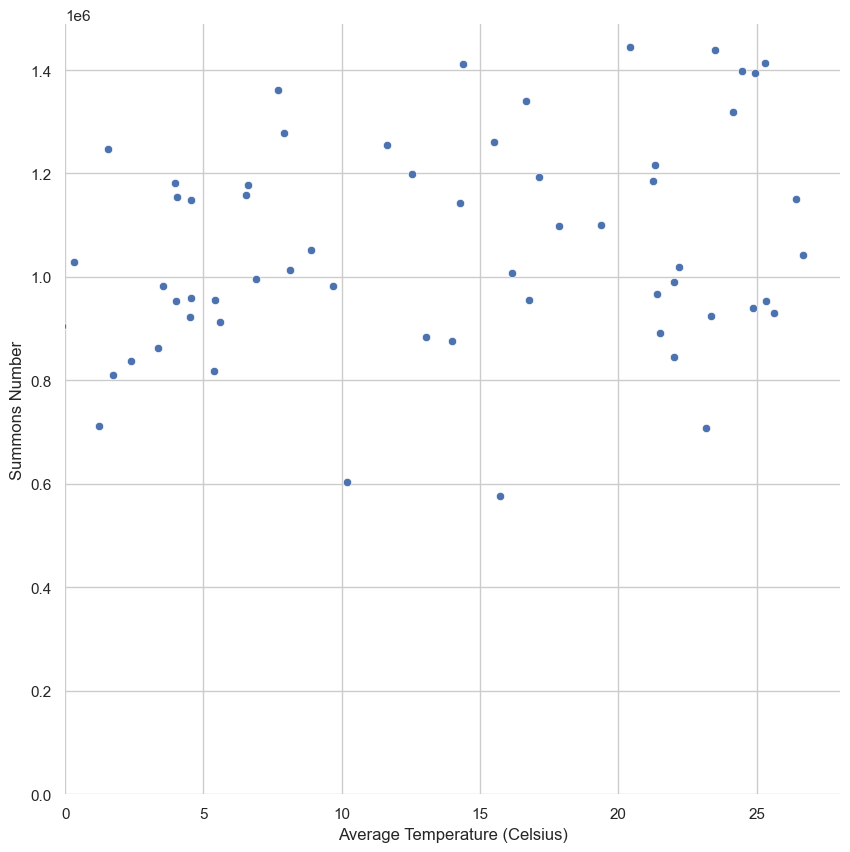

In [299]:
# Plot a scatter plot of Temp vs. Number of Citations
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)

with ProgressBar():
    sns.scatterplot(x="Average Temperature (Celsius)", y="Summons Number", data=datapoints, ax=ax)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)

#### Regplot

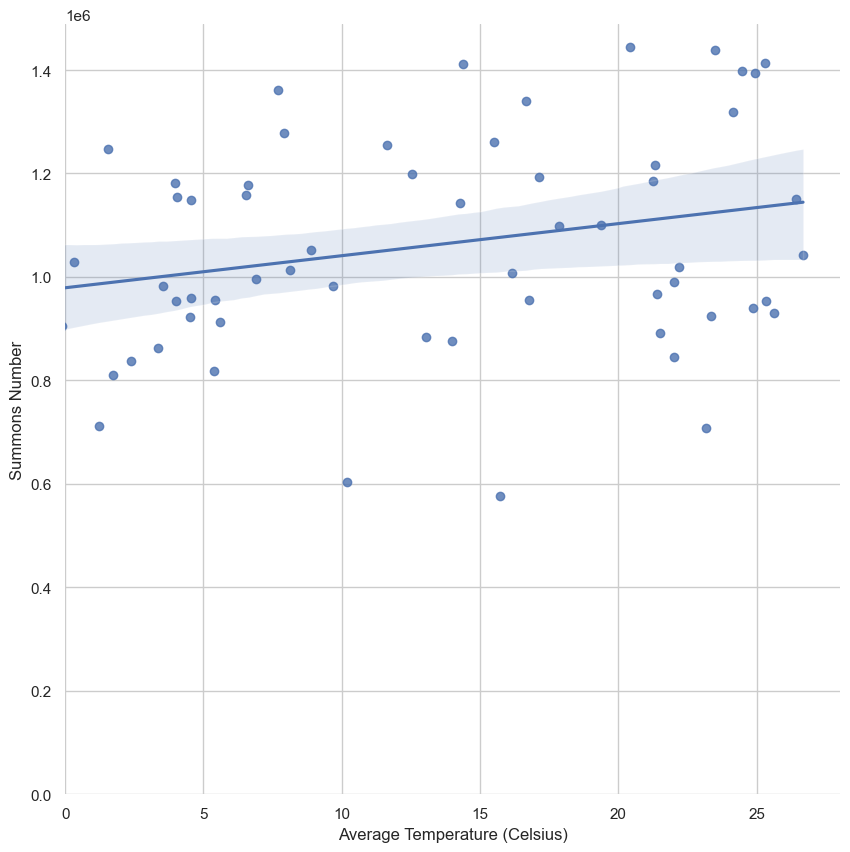

In [301]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)

with ProgressBar():
    sns.regplot(x="Average Temperature (Celsius)", y="Summons Number", data=datapoints, ax=ax, robust=True)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)

#### Parabolic Regplot

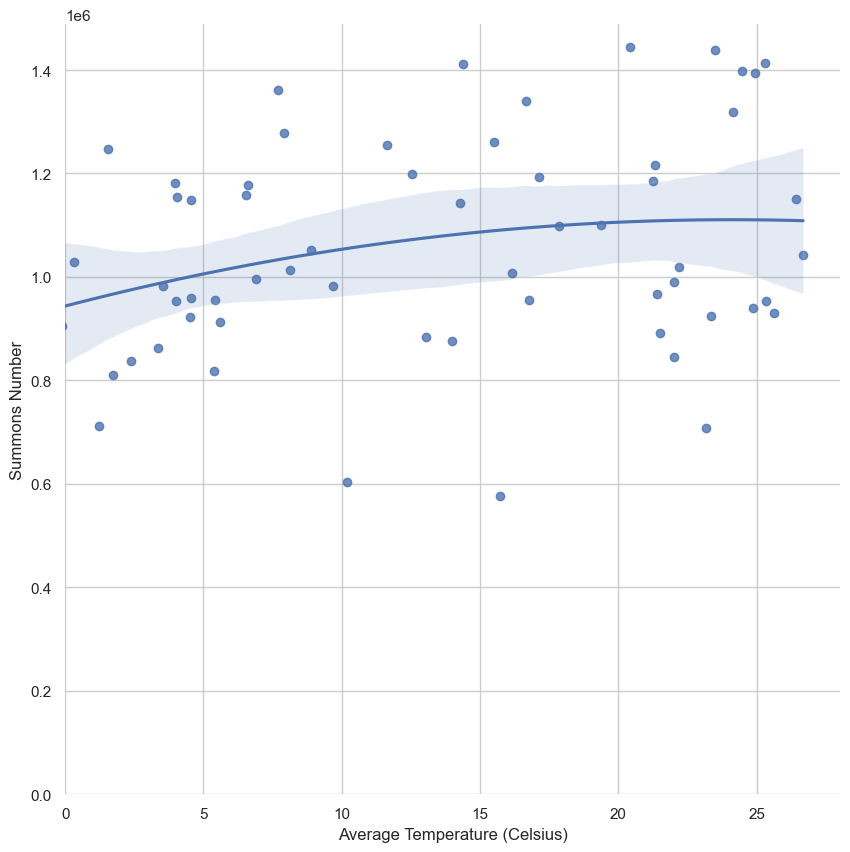

In [303]:
# Try a non-linear fit by setting the order parameter 
# to 2 (roughly parabolic shape)
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)

with ProgressBar():
    sns.regplot(x="Average Temperature (Celsius)", y="Summons Number", data=datapoints, ax=ax, order=2)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)

#### Violin Plot

In [304]:
# nyc_data_with_vehicle_age = dd.read_parquet('nyc_data_vehicleAge', engine='pyarrow')

row_filter = nyc_data_with_vehicle_age['Vehicle Color'].isin(['BLACK','WHITE','GREY','RED','GREEN','BLUE'])
column_filter = ['Vehicle Age','Vehicle Color']
ages_and_colors = nyc_data_with_vehicle_age[row_filter][column_filter]

with ProgressBar():
    datapoints_ages_and_colors = ages_and_colors.compute()

    sample_datapoints = ages_and_colors.sample(frac=0.10).compute()

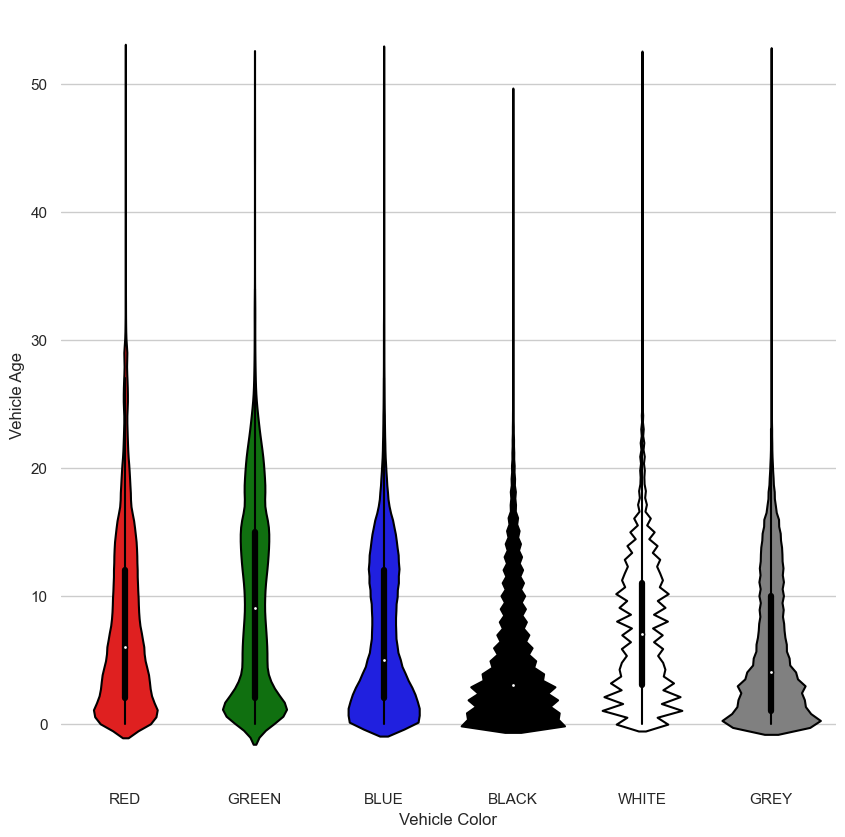

In [305]:
# Plot a violinplot to show the distributions of 
# vehicle ages grouped by vehicle color
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)
group_order = ["RED", "GREEN", "BLUE", "BLACK", "WHITE",  "GREY"]

sns.violinplot(x="Vehicle Color", y="Vehicle Age",  data=datapoints_ages_and_colors,
                   order=group_order,  palette=group_order, ax=ax)

#### Violin Plot of 10% Sample

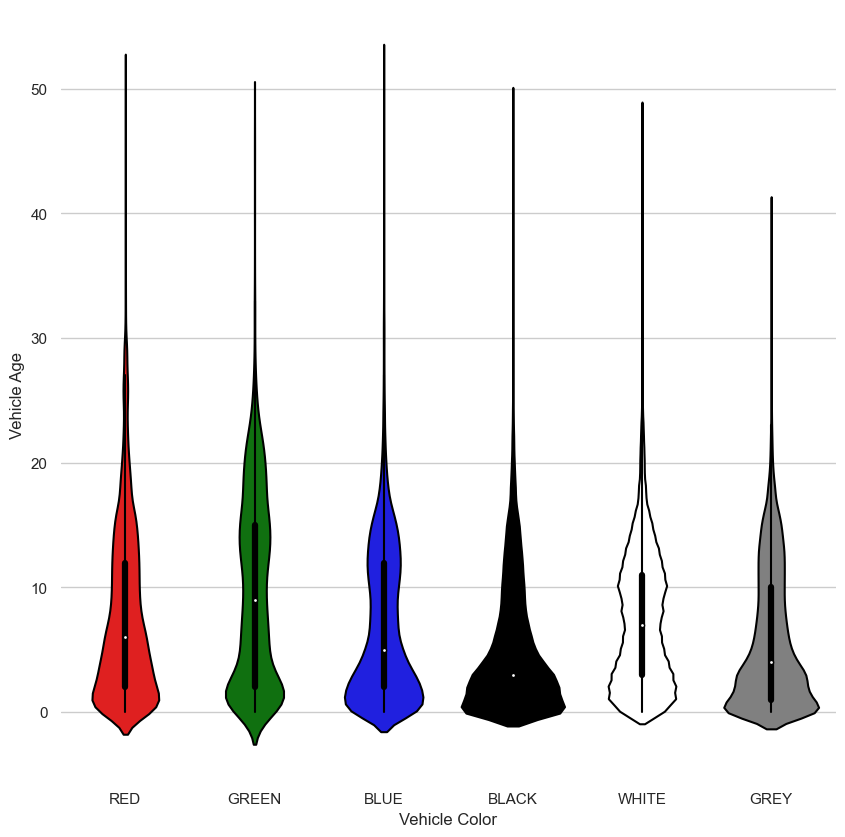

In [306]:
# Plot a violinplot of a random sample
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)

sns.violinplot(x="Vehicle Color", y="Vehicle Age", data=sample_datapoints,
                   order=group_order, palette=group_order, ax=ax)

#### Side by side of Violin plots

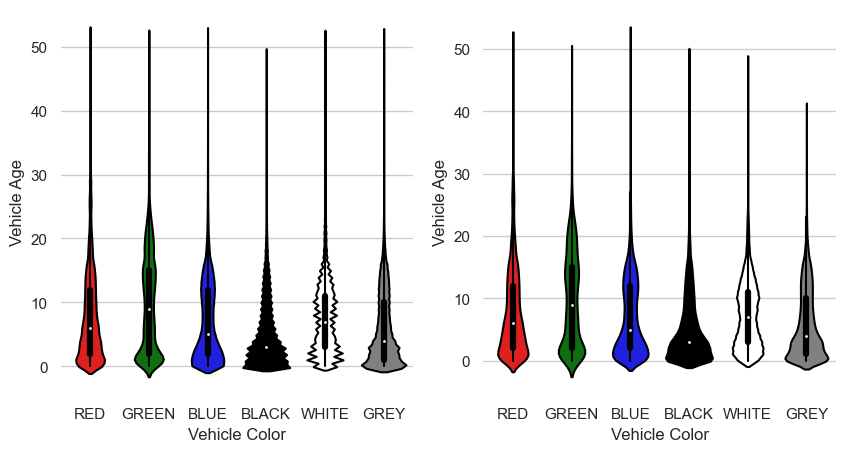

In [324]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

sns.set(style="whitegrid")
sns.despine(f, left=True, bottom=True)
group_order = ["RED", "GREEN", "BLUE", "BLACK", "WHITE",  "GREY"]

sns.violinplot(x="Vehicle Color", y="Vehicle Age",  data=datapoints_ages_and_colors,
                   order=group_order,  palette=group_order, ax=ax1);

sns.violinplot(x="Vehicle Color", y="Vehicle Age", data=sample_datapoints,
                   order=group_order, palette=group_order, ax=ax2);